# Moayed Haji Ali - 66688

# Imporing packages

In [208]:
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Plots
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, sigm, adam
import .Iterators: cycle, Cycle, take
using Knet

# Define Constants

In [209]:
ATYPE = Array{Float32}
DIMS = [28,28]
OUTPUT = 10;
MAX_ITERATIONS = 100
VALID = 5

5

# Loading training and testing data from Knet

In [210]:
include(Knet.dir("data","mnist.jl"))#include mnist related functions
dtrn, dtst = mnistdata(;batchsize=100, xtype=ATYPE);#data ready to use in convolutional

# Define the layers' structure and chain

In [211]:
struct Dense
    w; b; f; dprop; # w,x the activation function, and the probability of the dropout
    Dense(ftr, oput, actv = relu; dprop = 0, atype = ATYPE) = 
        new(param(oput, ftr; atype = atype), param0(oput, 1; atype = atype), actv, dprop) 
end
(m::Dense)(x) = m.f.(m.w * mat(dropout(x, m.dprop)) .+ m.b) # as the output of the conv layer will be 4D we need mat to make it 2D

In [212]:
struct Conv
    w; b; f; dprop; padding; stride
    Conv(w1, w2, cx, cy, actv = relu;dprop = 0, padding = 0, stride = 1, atype = ATYPE) = 
        new(param(w1, w2, cx, cy; atype = atype), param0(1, 1, cy, 1; atype = atype), actv, dprop, padding, stride)
end
(m::Conv)(x) = m.f.((conv4(m.w, dropout(x, m.dprop), padding = m.padding, stride = m.stride) .+ m.b))

In [213]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(m::Chain)(x) = (for l in m.layers; x = l(x); end; x)
(m::Chain)(x, y) = nll(m(x), y)
(m::Chain)(data::Data) = mean(m(x,y) for (x,y) in data)

# Define a train function using the previous chain of layers

In [214]:
function train(model, dtrn, dtst; iter = 500, valid = 10, file = nothing, lr = 0.15, optimizefun = sgd)
    if file != nothing && isfile(file)
        println("Pretrained model found. Do you want to train from scratch?")
        query = readline()[1]
        if query != 'y' && query != 'Y'
            r = Knet.load(file, "results")
            return Knet.load(file, "iter"), r[1], r[2], r[3], r[4]
        end
    end
    tst_loss = []; trn_loss = []; tst_err = []; trn_err = []
    push!(tst_loss, model(dtst))
    push!(trn_loss, model(dtrn))
    push!(tst_err, zeroone(model,dtst))
    push!(trn_err, zeroone(model,dtrn))
    println("Trining stated")
    for (i, _) in progress(enumerate(optimizefun(model, take(cycle(dtrn), iter) , lr = lr)))
        if i%valid == 0
            push!(tst_loss, model(dtst))
            push!(trn_loss, model(dtrn))
            push!(tst_err, zeroone(model,dtst))
            push!(trn_err, zeroone(model,dtrn))
        end
        nothing
    end
    if file != nothing
        Knet.save(file, "results", [tst_err, tst_loss, trn_err, trn_loss], "iter", 0:valid:iter)
    end
    println("Training finished")
    println("test data error rate: ", minimum(tst_err))
    println("train data error rate: ", minimum(trn_err))
    return 0:valid:iter, tst_err, tst_loss, trn_err, trn_loss
end

train (generic function with 1 method)

# Part 5: Train the Mnsit with Conv layer, pooling layer with 3 * 5x5 filters and a softmax classifier

In [215]:
#function to calculate the output size for the conv layer
function output_size(x::Int, w::Int, stride = 1, padding = 0)
    return Int(1 + floor((x-w+2*padding)/stride))
end

output_size (generic function with 5 methods)

In [222]:
#(m::Conv)(w1, w2, cx, cy, actv = relu; padding = 0, stride = 1, atype = ATYPE) 
cnn5 = Chain(
    Conv(5, 5, 1, 3, sigm),
    pool,
    Dense(output_size(output_size(DIMS[1], 5), 2; stride = 2) ^ 2 * 3, 10, identity)
);

In [223]:
iter, tst_err, tst_loss, trn_err, trn_loss = train(cnn5, dtrn, dtst, file = "part5cnn_tst.jld2",iter = 60000, valid = 600);

stdin> n
Pretrained model found. Do you want to train from scratch?


In [224]:
function plot_err(tst_err, trn_err)
    plot(iter, [tst_err, trn_err], label = ["test error" "train error"], xlabel="Iterations", ylabel="Error", ylim = [0.0, 0.09])
end

plot_err (generic function with 1 method)

In [225]:
function plot_loss(tst_loss, trn_loss)
    plot(iter, [tst_loss, trn_loss], label = ["test loss" "train loss"], xlabel="Iterations", ylabel="Loss", ylim = [0.0, 0.4])
end

plot_loss (generic function with 1 method)

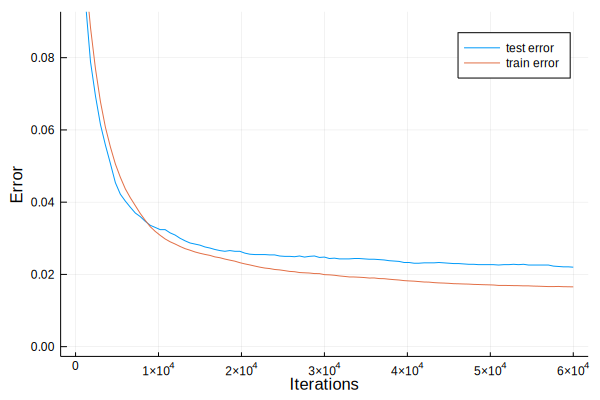

In [226]:
plot_err(tst_err, trn_err)

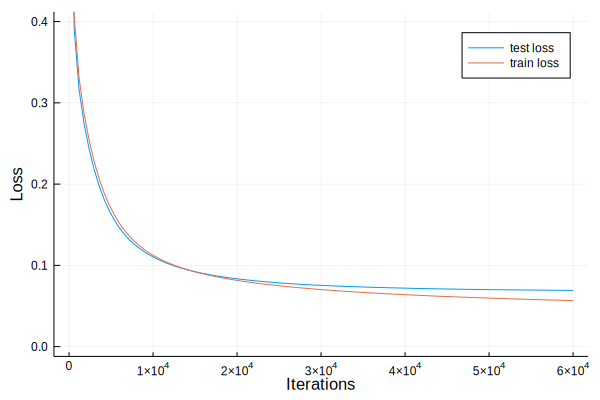

In [227]:
plot_loss(tst_loss, trn_loss)

# Part 6: Training the model using Adam optimizer

In [228]:
cnn_adam = Chain(
    Conv(5, 5, 1, 3, sigm),
    pool,
    Dense(output_size(output_size(DIMS[1], 5), 2; stride = 2) ^ 2 * 3, 10, identity)
);

In [229]:
iter, tst_err, tst_loss, trn_err, trn_loss = train(cnn_adam, dtrn, dtst, file = "AdamCnn.jld2", iter = 60000, valid = 600, optimizefun = adam);

stdin> n
Pretrained model found. Do you want to train from scratch?


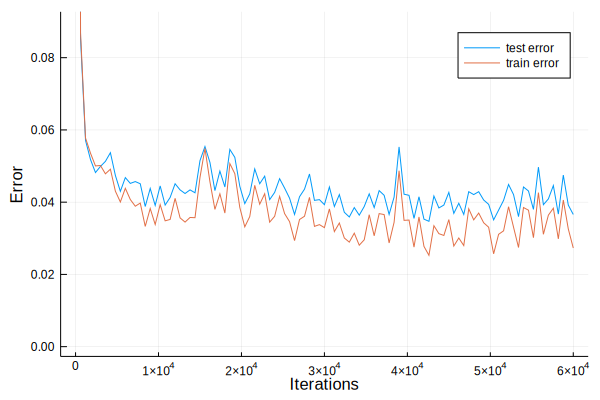

In [230]:
plot_err(tst_err, trn_err)

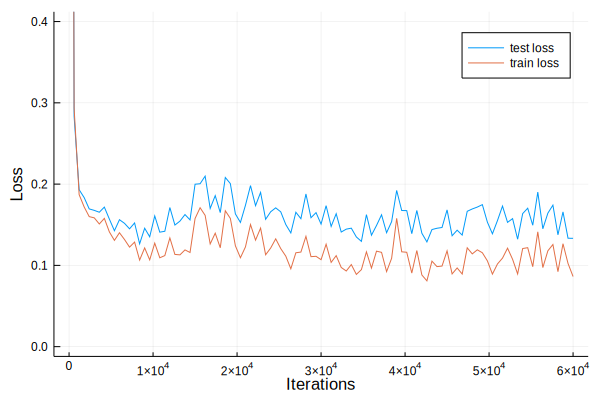

In [231]:
plot_loss(tst_loss, trn_loss)

# Part 7: Analyise different models to reach 100% accuracy on the data set with the least number of parameters

###  test 1: MLP with two hidden layers of size 50, 50 and relu activation function

In [232]:
# as we are trying to achieve highest accuracy on train data set, we will not use any dropout
test1_mlp = Chain(
    Dense(784, 50, relu),
    Dense(50, 50, relu),
    Dense(50, 10, identity)
    # 784*50 + 50 + 50 * 50 + 50 + 50 * 10 + 10 = 42310 parameters
)
println.(summary.(l != pool ? l.w : nothing for l in test1_mlp.layers))
iter, tst_err, tst_loss, trn_err, trn_loss = train(test1_mlp, dtrn, dtst, file = "Mlp2Layers.jld2", iter = 60000, valid = 600, optimizefun = sgd);

stdin> n
50×784 Param{Array{Float32,2}}
50×50 Param{Array{Float32,2}}
10×50 Param{Array{Float32,2}}
Pretrained model found. Do you want to train from scratch?


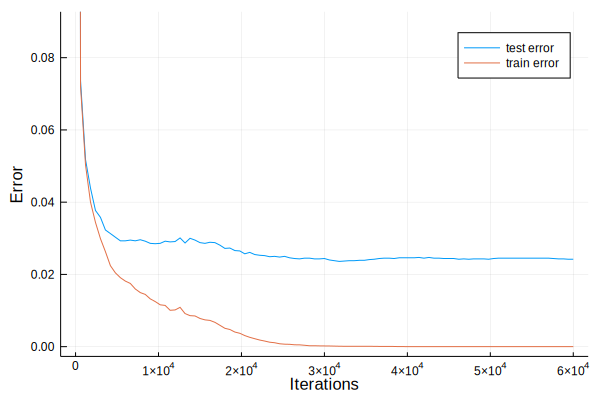

In [233]:
plot_err(tst_err, trn_err)

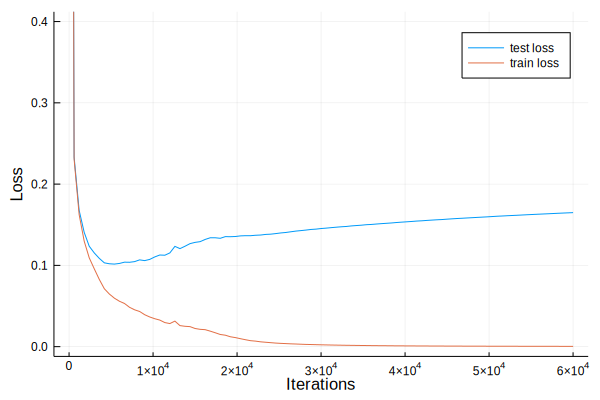

In [234]:
plot_loss(tst_loss, trn_loss)

### test2: CNN with 2 convolutional layers with 3x3 and 5x5 filters and a defult pooling operatin and one dense layer

In [235]:
function output_size(x, layers::Array)
    if size(layers,1) == 0
        return x
    end
    sz = output_size(x, layers[1]...)
    return output_size(sz, layers[2:end])
end

output_size (generic function with 5 methods)

In [236]:
test2_cnn = Chain(
    Conv(3, 3, 1, 20, relu),
    pool,
    Conv(3, 3, 20, 40, sigm),
    pool,
    Dense(output_size(DIMS[1], [3, [2,2], 3, [2, 2] ])^2 * 40, 10, identity)
)
println.(summary.(l != pool ? l.w : nothing for l in test2_cnn.layers))
#iter, tst_err, tst_loss, trn_err, trn_loss = train(test2_cnn, dtrn, dtst, file = "test2_cnn.jld2", iter = 10, valid = 600, optimizefun = sgd);

3×3×1×20 Param{Array{Float32,4}}
Nothing
3×3×20×40 Param{Array{Float32,4}}
Nothing
10×1000 Param{Array{Float32,2}}


In [198]:
test2_cnn = Chain(
    Conv(3, 3, 1, 20, relu),
    Conv(3, 3, 20, 10, relu),
    pool,
    Dense(output_size(DIMS[1], [3, 3, [2, 2]])^2 * 10, 10, identity)
    # 3×3×1×20 + 20 + 3×3×20×10 + 10 + 10×1440 + 10 = 16420 parameters
)
println.(summary.(l != pool ? l.w : nothing for l in test2_cnn.layers))
iter, tst_err, tst_loss, trn_err, trn_loss = train(test2_cnn, dtrn, dtst, file = "test2_cnn.jld2", iter = 30000, valid = 300, optimizefun = sgd);

stdin> y


┣████████████████████┫ [100.00%, 30000/30000, 03:17:38/03:17:38, 2.53i/s]  


3×3×1×20 Param{Array{Float32,4}}
3×3×20×10 Param{Array{Float32,4}}
Nothing
10×1440 Param{Array{Float32,2}}
Pretrained model found. Do you want to train from scratch?
Trining stated
Training finished
test data error rate: 0.013700000000000045
train data error rate: 4.999999999999449e-5


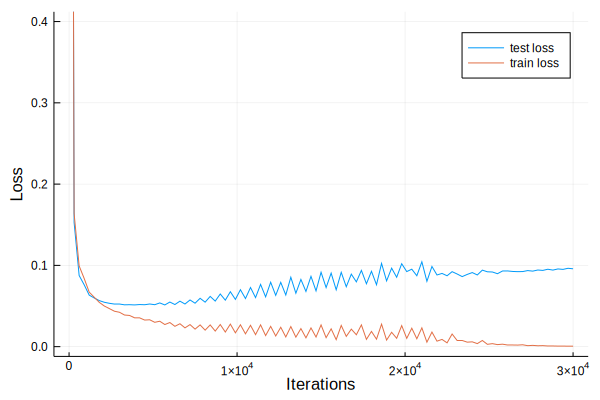

In [199]:
plot_loss(tst_loss, trn_loss)

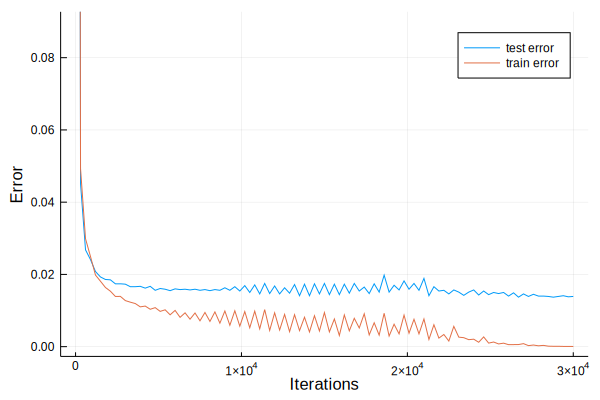

In [200]:
plot_err(tst_err, trn_err)

In [205]:
test3_cnn = Chain(
    Conv(3, 3, 1, 10, relu),
    pool,
    Conv(3, 3, 10, 20, sigm),
    pool,
    Dense(output_size(DIMS[1], [3, [2, 2], 3, [2, 2]])^2 * 20, 200, relu),
    Dense(200, 10, identity)
    # 5×5×1×40 + 40 + 3×3×40×20 + 20 + 10×2420 + 10 = 32470 parameters
)
println.(summary.(l != pool ? l.w : nothing for l in test3_cnn.layers))
iter, tst_err, tst_loss, trn_err, trn_loss = train(test3_cnn, dtrn, dtst, file = "test3_cnn.jld2", iter = 60000, valid = 600, optimizefun = sgd);

stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 01:51:16/01:51:16, 8.99i/s]  


3×3×1×10 Param{Array{Float32,4}}
Nothing
3×3×10×20 Param{Array{Float32,4}}
Nothing
200×500 Param{Array{Float32,2}}
10×200 Param{Array{Float32,2}}
Pretrained model found. Do you want to train from scratch?
Trining stated
Training finished
test data error rate: 0.0131
train data error rate: 3.333333333332966e-5


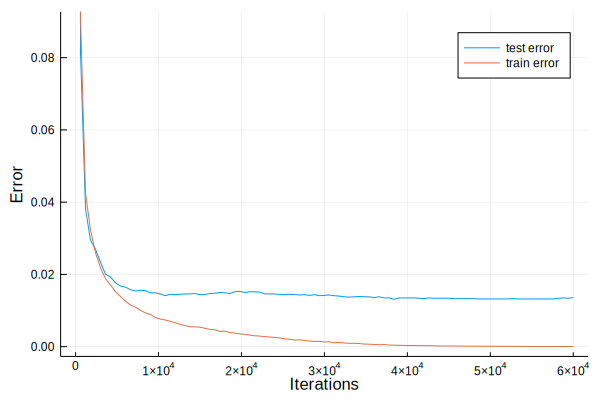

In [206]:
plot_err(tst_err, trn_err)

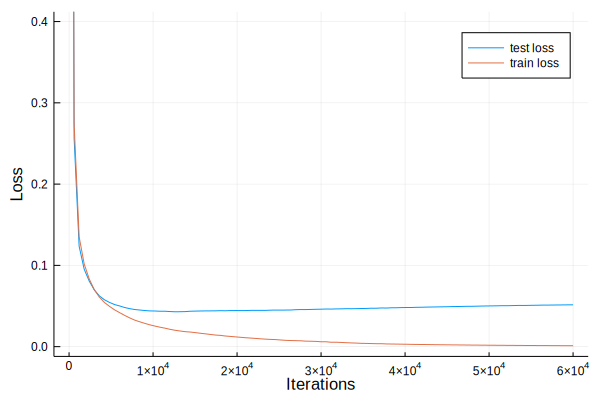

In [207]:
plot_loss(tst_loss, trn_loss)